# Imports

In [39]:
import h5py
import torch
import tyxe
import pyro
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from pyro import optim
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Data Importing and Preprocessing Functions

In [4]:
def get_data(fileName):
    
    file = h5py.File(fileName, 'r')
    
    boxes = file['t21_boxes']
    labels = file['tau_values']
    
    x_data = boxes[:]
    y_data = labels[:]

    x_data = np.float32(x_data)
    y_data = np.float32(y_data).reshape(-1, 1)
    
    return x_data, y_data

In [5]:
def scale(Ys): return [i*100 for i in Ys]
def descale(Ys): return [i/100 for i in Ys]

In [6]:
def convert_to_dataloader(x, y, batch_size):
    
    x_tensor = torch.Tensor(x)
    y_tensor = torch.Tensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    return dataloader

# Define Convolutional Neural Network (CNN)

In [32]:
class Convnet(nn.Module):

    def __init__(self):
        super(Convnet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 20, out_channels = 32, kernel_size = 3),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
                                   nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3),
                                   nn.MaxPool2d(2))

        

        self.avgpool = nn.AvgPool2d(2)
        
        self.fc1 = nn.Linear(254016*2, 192)
        self.fc2 = nn.Linear(192, 96)
        self.fc3 = nn.Linear(96, 24)
        self.fc4 = nn.Linear(24, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

# Define Bayesian Neural Network (BNN) from CNN

In [8]:
def create_model():
    net = Convnet()
    net = net.to(device)
    prior = tyxe.priors.IIDPrior(dist.Normal(torch.zeros(1, device=device), torch.ones(1, device=device)))
    likelihood = tyxe.likelihoods.HomoskedasticGaussian(dataset_size = 640, scale = 0.1)
    guide = partial(tyxe.guides.AutoNormal, init_loc_fn=tyxe.guides.PretrainedInitializer.from_net(net, prefix="net"), init_scale=1e-4)
    bnn = tyxe.VariationalBNN(net, prior, likelihood, guide)
    
    return bnn

# Training Function

In [9]:
def train(train_dl, val_dl, bnn, lr, epochs):
    errs_val = []
    lls_val = []
    errs_train = []
    lls_train = []
    
    target_err = [0.0001]
    iter = [0]

    def callback(b, i, avg_elbo):
        avg_err, avg_ll = 0., 0.
        avg_err_train, avg_ll_train = 0., 0.
        b.eval()
        for x, y in train_dl:
            err_train, ll_train = b.evaluate(x.to(device), y.to(device), num_predictions=batch_size)
            avg_err_train += err_train / len(train_dl.sampler)
            avg_ll_train += ll_train / len(train_dl.sampler)
    
        errs_train.append(avg_err_train)
        lls_train.append(avg_ll_train)
            
        for x, y in val_dl:
            err, ll = b.evaluate(x.to(device), y.to(device), num_predictions=batch_size)
            avg_err += err / len(val_dl.sampler)
            avg_ll += ll / len(val_dl.sampler)
    
        errs_val.append(avg_err)
        lls_val.append(avg_ll)
        
        iter[0] += 1
        
        print(f"Epoch={iter[0]}\nTrain: Test Error={100 * avg_err_train:.2f}%; Log Likelihood={avg_ll_train:.4f}")
        print(f"Val: Test Error={100 * avg_err:.2f}%; Log Likelihood={avg_ll:.4f}")
        
        b.train()
        
        if(avg_err.cpu().numpy() < target_err[0]):
            return True

    
    optim = pyro.optim.Adam({"lr": lr})
    
    # Variational BNN
    with tyxe.poutine.local_reparameterization(reparameterizable_functions=["conv2d", "linear"]):
        bnn.fit(train_dl, optim, epochs, callback=callback, device=device, closed_form_kl = True)

    errors_nontensor = np.array([i.cpu().numpy() for i in errs_val]).flatten()
    errors_train_nontensor = np.array([i.cpu().numpy() for i in errs_train]).flatten()
    lls_nontensor = np.array([i.cpu().numpy() for i in lls_val]).flatten()
    lls_train_nontensor = np.array([i.cpu().numpy() for i in lls_train]).flatten()

    return [errors_nontensor, errors_train_nontensor, lls_nontensor, lls_train_nontensor]

# Testing Function

In [10]:
def test_model(bnn):
    
    preds = []
    for x, _ in test_dl:
        with tyxe.poutine.local_reparameterization(reparameterizable_functions=["conv2d", "linear"]):
            preds.append(bnn.predict(x.to(device), aggregate = True, num_predictions=batch_size))
    
    y_pred = [i[0].detach().cpu() for i in preds]
    y_uncertainties = [i[1].detach().cpu() for i in preds]
    
    y_pred = torch.cat(y_pred).numpy()
    y_uncertainties = torch.cat(y_uncertainties).numpy()
    
    y_test_descaled = (y_test/100).flatten()
    y_pred_descaled = (y_pred/100).flatten()
    y_uncertainties_descaled = (y_uncertainties/100).flatten()
    
    error = [abs(y_test_descaled[i]-y_pred_descaled[i])/y_test_descaled[i] for i in range(len(y_test_descaled))]

    mse = mean_squared_error(y_test_descaled, y_pred_descaled, squared=True)
    avg_err = sum(error)/len(error)*100
    max_err = max(error)*100
    min_err = min(error)*100
    print("Mean Squared Error:", mse)
    print(f'Average Error = {avg_err}%')
    print(f"Max Error = {max_err}%, Min Error = {min_err}%")
    
    within_std = 0
    for i in range(0, 200):
        if(y_pred_descaled[i] + y_uncertainties_descaled[i] > y_test_descaled[i]) and (y_pred_descaled[i] - y_uncertainties_descaled[i] < y_test_descaled[i]):
            within_std += 1

    percent_within_std = within_std/200*100
    
    print(f"% of Predictions Within 1 STD of True value: {percent_within_std}%")

    return [y_pred_descaled, y_uncertainties_descaled, mse, avg_err, max_err, min_err, percent_within_std]

# Data Importing and Preprocessing

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16

fileName = "/home/laplante/data/t21/all_snapshots.hdf5"
x_data, y_data = get_data(fileName)

x_tr, x_test, y_tr, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=30)
y_test = y_test*100
test_dl = convert_to_dataloader(x_test, y_test, batch_size)

# 5 Fold Cross Validation (CV) Training Loop

In [12]:
train_hist_cv = []
test_hist_cv = []
for i in range(0, 5):

    print(f"Fold {i+1}")
    torch.cuda.empty_cache()
    pyro.clear_param_store()

    x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.2)
    y_train, y_val = scale([y_train, y_val])
    
    train_dl = convert_to_dataloader(x_train, y_train, batch_size)
    val_dl = convert_to_dataloader(x_val, y_val, batch_size)
    
    bnn = create_model()

    train_hist = train(train_dl, val_dl, bnn, 0.00001, 10)
    test_hist = test_model(bnn)

    train_hist_cv.append(train_hist)
    test_hist_cv.append(test_hist)

Fold 1
Epoch=1
Train: Test Error=19.35%; Log Likelihood=-8.1902
Val: Test Error=19.63%; Log Likelihood=-8.3312
Epoch=2
Train: Test Error=0.28%; Log Likelihood=1.2403
Val: Test Error=0.33%; Log Likelihood=1.2153
Epoch=3
Train: Test Error=0.13%; Log Likelihood=1.3136
Val: Test Error=0.17%; Log Likelihood=1.2948
Epoch=4
Train: Test Error=0.12%; Log Likelihood=1.3164
Val: Test Error=0.12%; Log Likelihood=1.3169
Epoch=5
Train: Test Error=0.14%; Log Likelihood=1.3065
Val: Test Error=0.14%; Log Likelihood=1.3064
Epoch=6
Train: Test Error=0.09%; Log Likelihood=1.3346
Val: Test Error=0.09%; Log Likelihood=1.3316
Epoch=7
Train: Test Error=0.02%; Log Likelihood=1.3653
Val: Test Error=0.04%; Log Likelihood=1.3593
Epoch=8
Train: Test Error=0.04%; Log Likelihood=1.3565
Val: Test Error=0.06%; Log Likelihood=1.3499
Epoch=9
Train: Test Error=0.02%; Log Likelihood=1.3679
Val: Test Error=0.04%; Log Likelihood=1.3601
Epoch=10
Train: Test Error=0.02%; Log Likelihood=1.3674
Val: Test Error=0.04%; Log Likeli

# Plot Training Error History

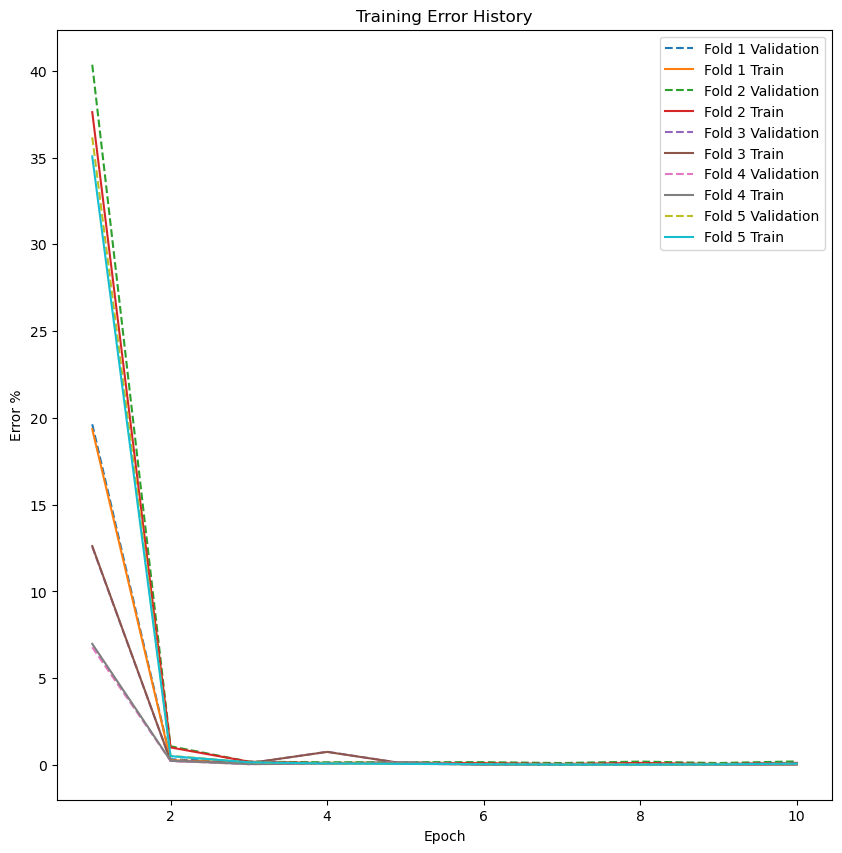

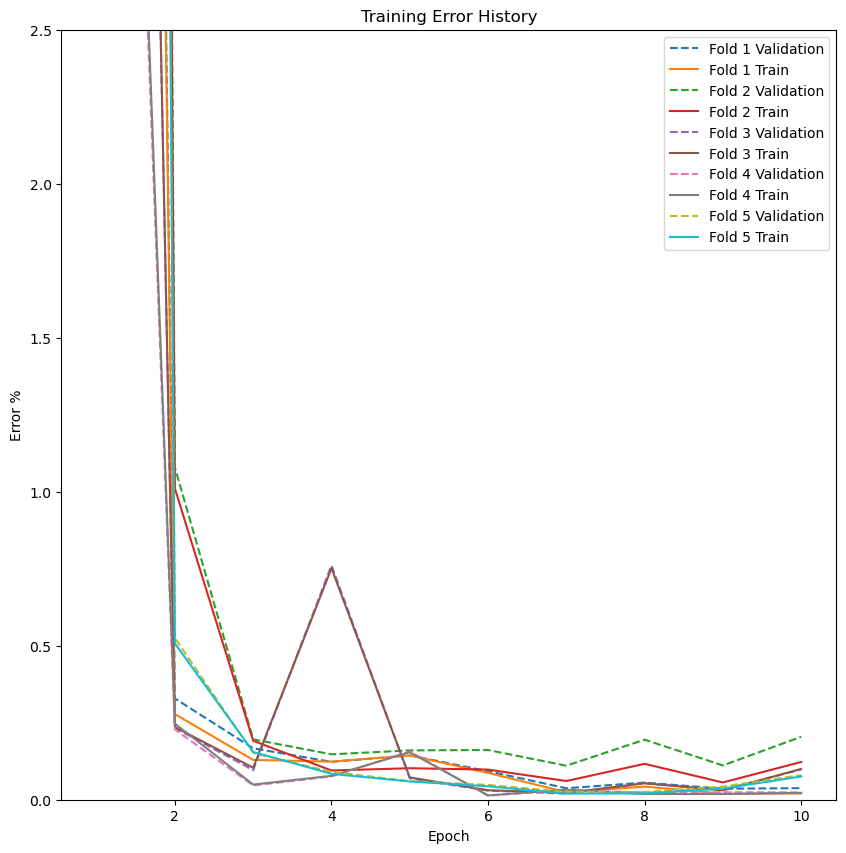

In [18]:
val_errors = [i[0] for i in train_hist_cv]
train_errors = [i[1] for i in train_hist_cv]
Folds = [f"Fold {i+1}" for i in range(5)]

plt.figure(figsize=(10,10))
plt.xlabel("Epoch")
plt.ylabel("Error %")
plt.title("Training Error History")

for val_error, train_error, fold in zip(val_errors, train_errors, Folds):
    plt.plot([i for i in range(1, 11)], val_error*100, label = f"{fold} Validation", ls = '--')
    plt.plot([i for i in range(1, 11)], train_error*100, label = f"{fold} Train")

plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.xlabel("Epoch")
plt.ylabel("Error %")
plt.title("Training Error History")
plt.ylim(0, 2.5)
for val_error, train_error, fold in zip(val_errors, train_errors, Folds):
    plt.plot([i for i in range(1, 11)], val_error*100, label = f"{fold} Validation", ls = '--')
    plt.plot([i for i in range(1, 11)], train_error*100, label = f"{fold} Train")

plt.legend()
plt.show()

# Plot Training Log Likelihood History

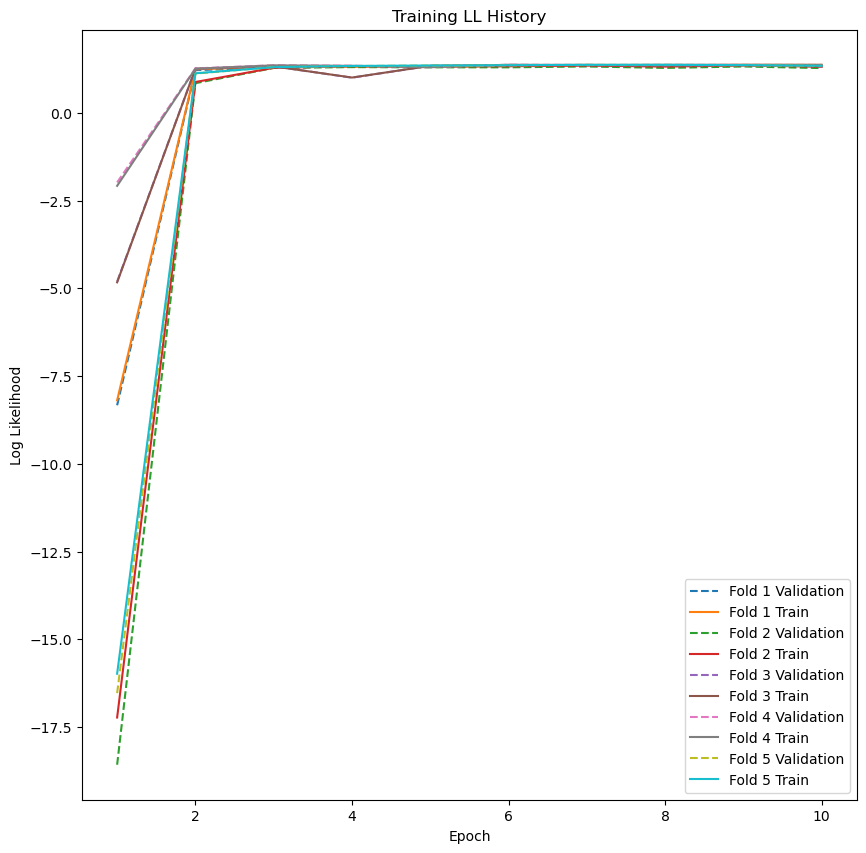

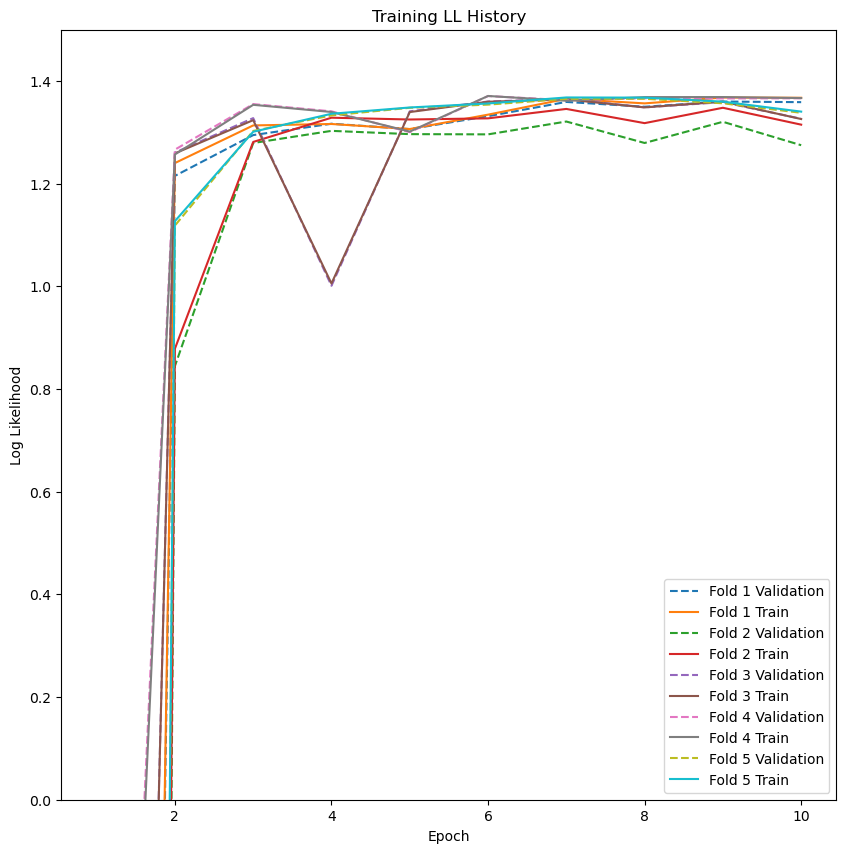

In [35]:
val_lls = [i[2] for i in train_hist_cv]
train_lls = [i[3] for i in train_hist_cv]
Folds = [f"Fold {i+1}" for i in range(5)]

plt.figure(figsize=(10,10))
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Training LL History")

for val_ll, train_ll, fold in zip(val_lls, train_lls, Folds):
    plt.plot([i for i in range(1, 11)], val_ll, label = f"{fold} Validation", ls = '--')
    plt.plot([i for i in range(1, 11)], train_ll, label = f"{fold} Train")

plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.title("Training LL History")
plt.ylim(0, 1.5)

for val_ll, train_ll, fold in zip(val_lls, train_lls, Folds):
    plt.plot([i for i in range(1, 11)], val_ll, label = f"{fold} Validation", ls = '--')
    plt.plot([i for i in range(1, 11)], train_ll, label = f"{fold} Train")

plt.legend()
plt.show()

# 5 Fold CV Model Testing Summaries

In [33]:
#[y_pred_descaled, y_uncertainties_descaled, mse, avg_err, max_err, min_err, percent_within_std] each array in test_hist_cv has

Folds = [f"Fold {i+1}" for i in range(5)]
Folds.append("Average")
mses = [i[2] for i in test_hist_cv]
avg_errs = [i[3] for i in test_hist_cv]
max_errs = [i[4] for i in test_hist_cv]
min_errs = [i[5] for i in test_hist_cv]
percent_within_std = [i[6] for i in test_hist_cv]
for i in [mses, avg_errs, max_errs, min_errs, percent_within_std]:
    i.append(sum(i)/len(i))


table = pd.DataFrame({"Fold": Folds, "MSE": mses, "Average Error": avg_errs, "Max Errors": max_errs, 
                      "Min Errors": min_errs, "% Within 1 STD": percent_within_std})

table

,Fold,MSE,Average Error,Max Errors,Min Errors,% Within 1 STD
0,Fold 1,3.095493e-08,0.256900,0.816943,0.001798,100.0
1,Fold 2,1.485068e-07,0.548668,1.808394,0.004276,100.0
2,Fold 3,9.997825e-08,0.498131,1.407507,0.007086,100.0
3,Fold 4,2.766581e-08,0.236591,1.009266,0.000640,100.0
4,Fold 5,8.178947e-08,0.447552,1.193533,0.004776,100.0
5,Average,7.777905e-08,0.397568,1.247129,0.003715,100.0


# Plot out Sample Predicted vs True $\tau$ Values

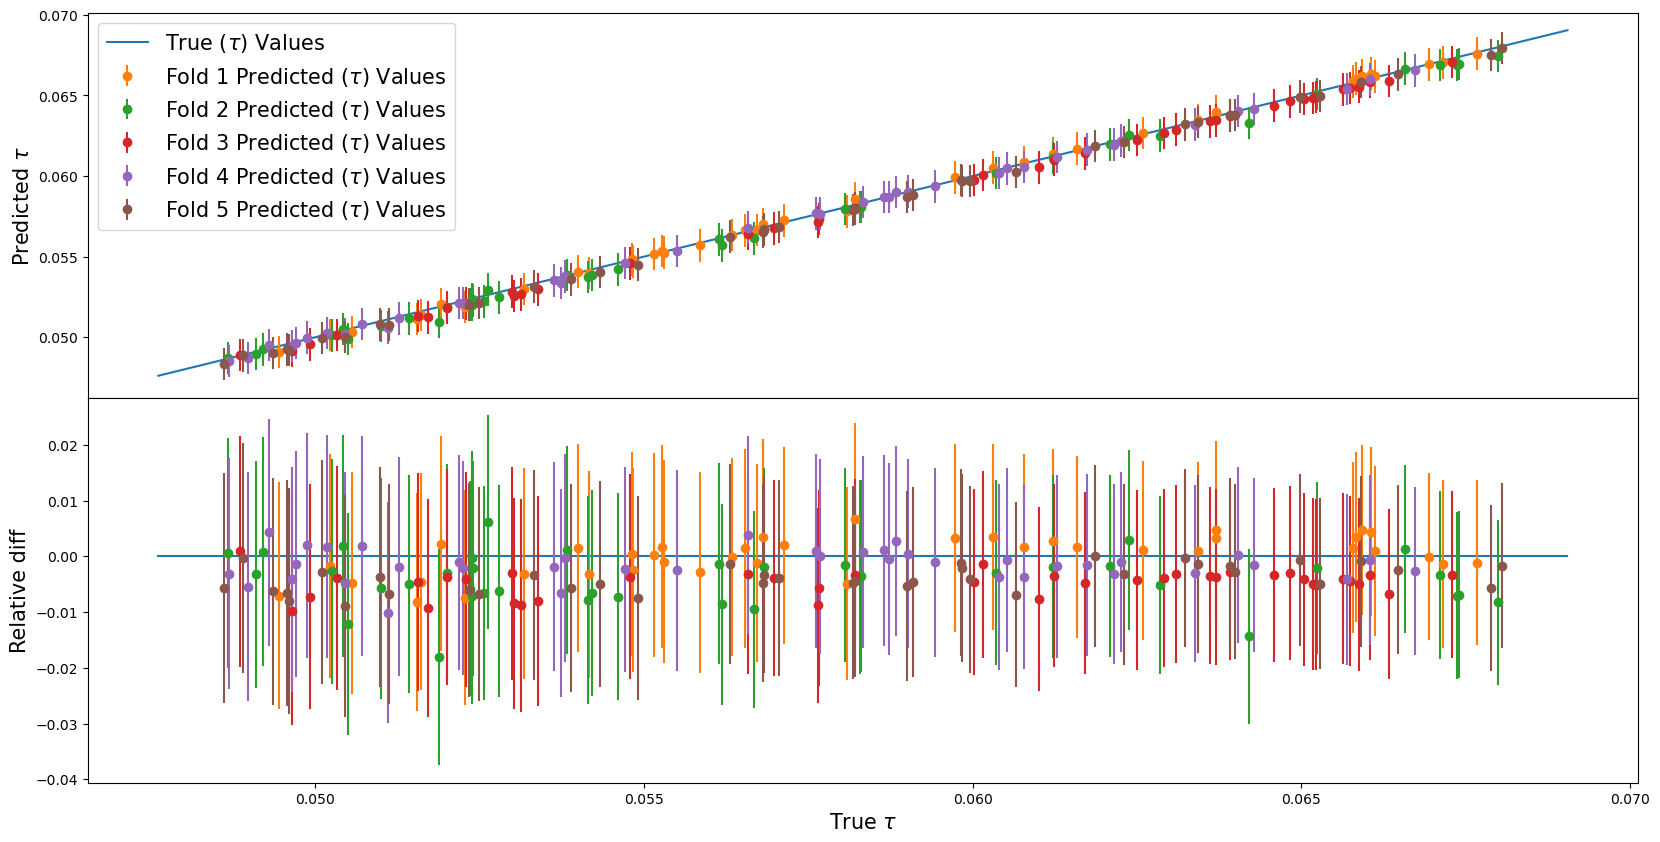

In [38]:
Folds = [f"Fold {i+1}" for i in range(5)]
y_pred_descaleds = [i[0] for i in test_hist_cv]
y_uncertainties_descaleds = [i[1] for i in test_hist_cv]
y_test_descaled = y_test/100

fully_accurate = np.linspace(y_test_descaled.min()-0.001, y_test_descaled.max()+0.001, 200)

fig, axs = plt.subplots(2, 1, sharex=True)

fig.subplots_adjust(hspace=0)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[1].plot(fully_accurate, np.zeros(200))
axs[0].plot(fully_accurate, fully_accurate, label = (r"True $(\tau)$ Values"))
starts = [0, 40, 80, 120, 160]
ends = [40, 80, 120, 160, -1]
for fold, y_pred_descaled, y_uncertainties_descaled, start, end in zip(Folds, y_pred_descaleds, y_uncertainties_descaleds, starts, ends):

    yerr = [y_uncertainties_descaled.flatten()[start:end], y_uncertainties_descaled.flatten()[start:end]]
    axs[0].errorbar(y_test_descaled[start:end], y_pred_descaled[start:end], yerr=yerr, fmt = 'o', label = (fold+r" Predicted $(\tau)$ Values"))
    
    relative_error = np.array([(y_pred_descaled[i]-y_test_descaled[i])/y_test_descaled[i] for i in range(len(y_test_descaled))]).flatten()
    rel_err_bars = [y_uncertainties_descaled[i]/y_test_descaled[i] for i in range(len(y_test_descaled))]
    rel_err_bars = np.array(rel_err_bars).flatten()
    axs[1].errorbar(y_test_descaled[start:end], relative_error[start:end], yerr=rel_err_bars[start:end], fmt='o', label = f"{fold} Predicted $(\tau)$ Values")

axs[0].legend(fontsize = 15)
axs[0].set_ylabel(r"Predicted $\tau$", fontsize=15)
axs[1].set_ylabel("Relative diff", fontsize=15)
axs[1].set_xlabel(r"True $\tau$", fontsize=15)
plt.show()

# Plot out Average Predicted vs True $\tau$ Values

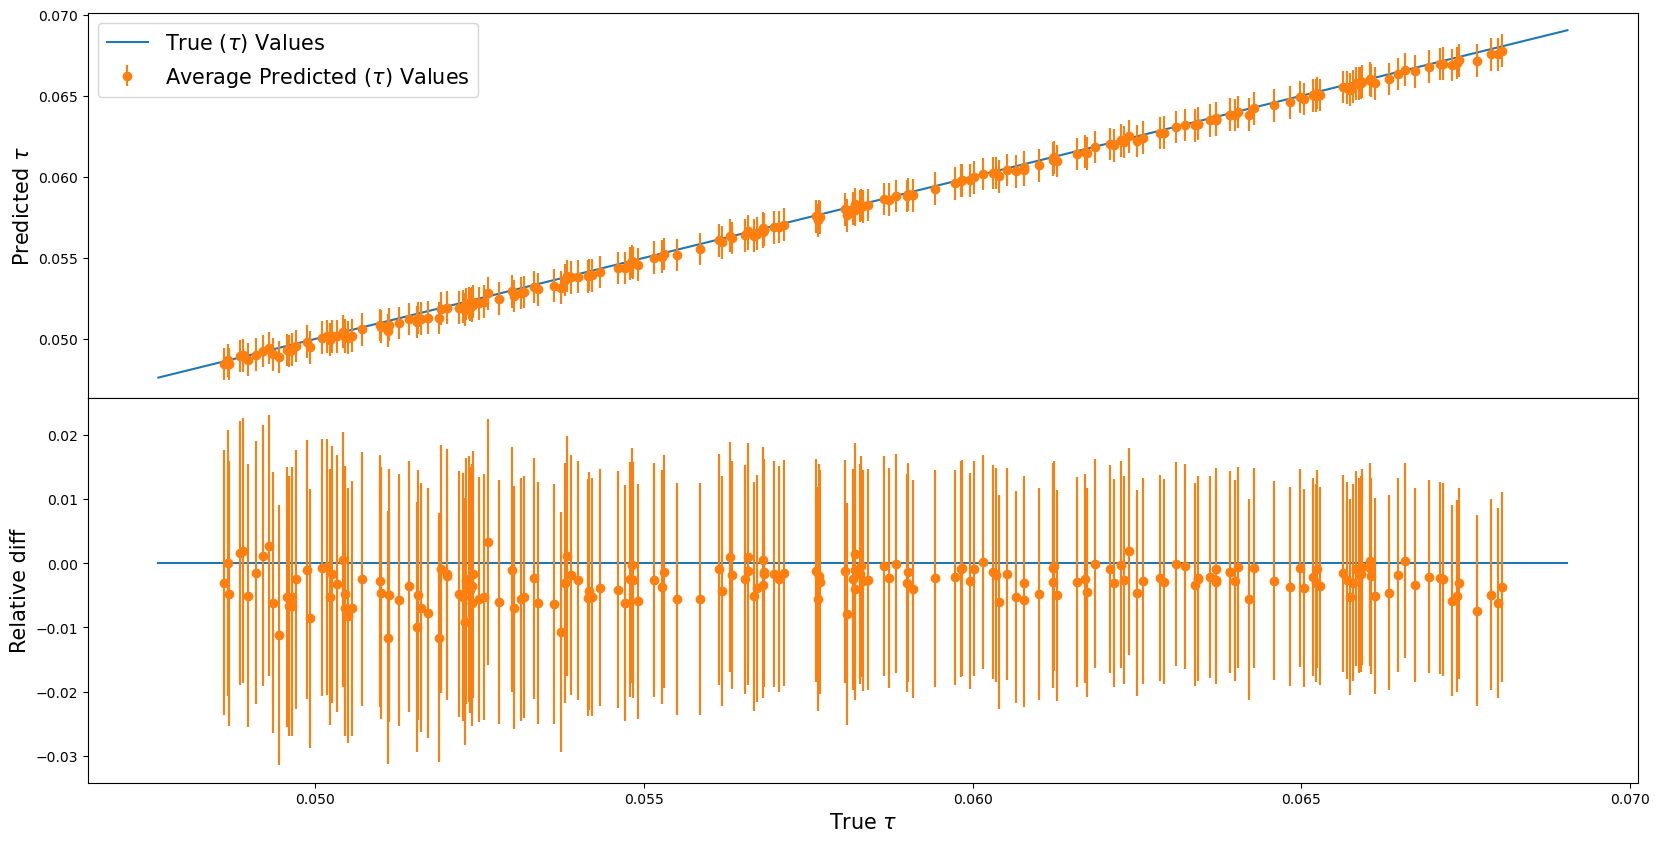

In [30]:
Folds = [f"Fold {i+1}" for i in range(5)]
y_pred_descaled = np.mean([i[0] for i in test_hist_cv], axis=0)
y_uncertainties_descaleds = np.mean([i[1] for i in test_hist_cv], axis=0)
y_test_descaled = y_test/100


fully_accurate = np.linspace(y_test_descaled.min()-0.001, y_test_descaled.max()+0.001, 200)

fig, axs = plt.subplots(2, 1, sharex=True)

#plt.xlabel(r"Actual $(\tau)$")
#plt.ylabel(r"Predicted $(\tau)$")
#plt.title(r"Predicted vs Actual $(\tau)$ Values")
fig.subplots_adjust(hspace=0)
#plt.figure(figsize=(20,5))
fig.set_figheight(10)
fig.set_figwidth(20)

axs[1].plot(fully_accurate, np.zeros(200))
axs[0].plot(fully_accurate, fully_accurate, label = (r"True $(\tau)$ Values"))
starts = [0, 40, 80, 120, 160]
ends = [40, 80, 120, 160, -1]

yerr = [y_uncertainties_descaled.flatten(), y_uncertainties_descaled.flatten()]
axs[0].errorbar(y_test_descaled, y_pred_descaled, yerr=yerr, fmt = 'o', label = (r"Average Predicted $(\tau)$ Values"))

relative_error = np.array([(y_pred_descaled[i]-y_test_descaled[i])/y_test_descaled[i] for i in range(len(y_test_descaled))]).flatten()
rel_err_bars = [y_uncertainties_descaled[i]/y_test_descaled[i] for i in range(len(y_test_descaled))]
rel_err_bars = np.array(rel_err_bars).flatten()
axs[1].errorbar(y_test_descaled, relative_error, yerr=rel_err_bars, fmt='o', label = f"Average Predicted $(\tau)$ Values")

axs[0].legend(fontsize = 15)
axs[0].set_ylabel(r"Predicted $\tau$", fontsize=15)
axs[1].set_ylabel("Relative diff", fontsize=15)
axs[1].set_xlabel(r"True $\tau$", fontsize=15)
plt.show()

# Convolutional Visualization

In [13]:
conv1 = bnn.net.conv1.eval()
conv2 = bnn.net.conv2.eval()
conv3 = bnn.net.conv3.eval()

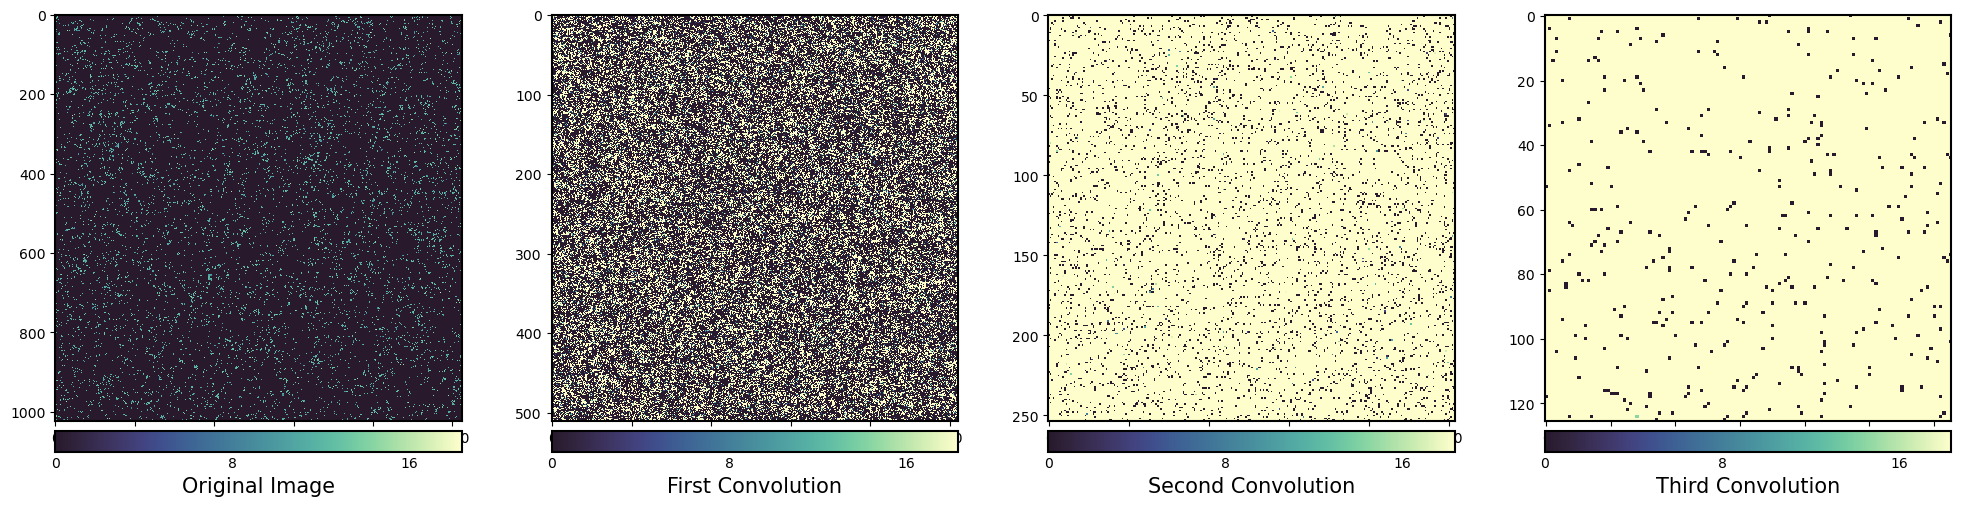

In [35]:
import seaborn_image as isns
firstimg = x_test[0]
firstimgtest = np.expand_dims(firstimg, axis=0)

firstimg_tensor = torch.tensor(firstimgtest).to(device)
secondimg = conv1(firstimg_tensor)
thirdimg = conv2(secondimg)
fourthimg = conv3(thirdimg)

imgs = [firstimg[0], secondimg[0][0].cpu().numpy(), thirdimg[0][0].cpu().numpy(), fourthimg[0][0].cpu().numpy()]

labels = ["Original Image", "First Convolution", "Second Convolution", "Third Convolution"]

g = isns.ImageGrid(imgs, orientation="h", vmin = firstimg[0].min(), vmax = firstimg[0].max(),
                   height=5, col_wrap=4, cbar_label = labels, showticks= True)

# Save Training and Testing history for later purposes

In [46]:
import dill

with open('bnn_flipout_data.pickle', 'wb') as handle:
    dill.dump([test_hist_cv, train_hist_cv], handle)

In [1]:
import dill

with open('bnn_flipout_data.pickle', 'rb') as f:
    test_hist_cv, train_hist_cv = dill.load(f)

# Clears Cuda Memory Usage

In [107]:
import gc
import pyro
import torch

bnn = None
net = None
train_dl = None
test_dl = None
torch.cuda.empty_cache()
pyro.clear_param_store()
gc.collect()

! nvidia-smi

Tue Nov 21 13:52:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:1B:00.0 Off |                    0 |
|  0%   38C    P0    76W / 300W |  45385MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:1C:00.0 Off |                    0 |
|  0%   